---
# Exercise

1 - create the geodataframe of the [libraries](https://opendata.anagrafe.iccu.sbn.it/territorio.zip) of Italy
  - data from the italian [Ministry of Culture](https://anagrafe.iccu.sbn.it/it/open-data/)
  - count the total of the libraries for each muncipality of Lombardia

2 - identify the difference of municipalities in Lombardia in the year [2022](https://github.com/napo/geospatial_datascience_unitn_2023/raw/main/data/istat/municipalities_lombardia_2022.parquet) with the year [2023](https://github.com/napo/geospatial_datascience_unitn_2023/raw/main/data/istat/municipalities_lombardia_2023.parquet)
  - identify which municipalities are created from aggregation to others
  - find the biggest new municipality of Lombardia and show all the italian municipalities with bordering it
  - create the macroarea of all the municipalities bordering with it
  - for each library in the macro-area, calculate how many monumental trees have been within a 500m radius
  
3 - create a polygon that contains all the monumental trees inside the province of the area
  - identify all the libraries in this provice which are within 2km of each other
  - save the polygon in geopackage with the attribute "description" with the name of the library

4 - create the polygon of the Island of Elba from the layer of municipalities with functions of overlay

---

# Solutions

## learning objectives
* repeat the concepts on the previous lesson
* spatial sql
* errors with the simplified boundaries
* convex hull / concave hull / alphashape
* nearest_points


## Setup

In [4]:
try:
  import pygeos
except ModuleNotFoundError as e:
  !pip install pygeos==0.14
  import pygeos


In [5]:
# needed to use the method .explore in geopandas in colab
try:
  import mapclassify 
except ModuleNotFoundError as e:
  !pip install mapclassify==2.6.0
  import mapclassify
if mapclassify.__version__ != "2.6.0":
  !pip install mapclassify==2.6.0
  import mapclassify 

In [6]:
try:
  import geopandas as gpd
except ModuleNotFoundError as e:
  !pip install geopandas==0.14.0
  import geopandas as gpd
if gpd.__version__ != "0.14.0":
  !pip install -U geopandas==0.14.0
  import geopandas as gpd

--- 

### Import of the packages

In [7]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.simplefilter("ignore")
pd.options.mode.chained_assignment = None

# 1 - create the geodataframe of the [libraries](https://opendata.anagrafe.iccu.sbn.it/territorio.zip) of Italy

In [8]:
urlfile = "https://opendata.anagrafe.iccu.sbn.it/territorio.zip"

In [9]:
libraries = pd.read_csv(urlfile, sep=";")

In [10]:
libraries.head(5)

,codice-isil,codice-sbn,denominazione,indirizzo,frazione,cap,comune,codice istat comune,provincia,regione,codice istat provincia,latitudine,longitudine,telefono,fax,email,url
0,IT-AG0001,AGR27,Biblioteca della Soprintendenza per i beni cul...,Contrada S. Nicola,NaN,92100.0,Agrigento,84001,Agrigento,SICILIA,84,"37,3361677","13,5880717",+39 0922595830,NaN,NaN,NaN
1,IT-AG0005,NaN,Biblioteca dell'Archivio di Stato di Agrigento,via Mazzini 185,NaN,92100.0,Agrigento,84001,Agrigento,SICILIA,84,"37,3221644312329","13,5886026454773",+39 0922602494,+39 0922613242,as-ag@cultura.gov.it,http://www.archiviodistatoagrigento.benicultur...
2,IT-AG0006,PBED8,Biblioteca del Seminario vescovile,Piazza don Minzoni,NaN,92100.0,Agrigento,84001,Agrigento,SICILIA,84,"37,3137125","13,5749656",+39 0922.20226,+39 0922.490024,studioteologicoagrigento@gmail.com,NaN
3,IT-AG0007,AGR01,Biblioteca Comunale Franco La Rocca,Piazzale Aldo Moro 3,NaN,92100.0,Agrigento,84001,Agrigento,SICILIA,84,"37,3095818","13,586151",+39 0922595166,+39 0922401246,biblioteca.larocca@comune.agrigento.it,http://www.opacagrigento.it/biblioteche/bi_1.html
4,IT-AG0008,NaN,Biblioteca comunale Santo Spirito. Sezione est...,Via Belvedere 127,Giardina Gallotti,92010.0,Agrigento,84001,Agrigento,SICILIA,84,"37,4050904","13,5291051",+39 0922410117,NaN,NaN,NaN


In [11]:
libraries.columns

Index(['codice-isil', 'codice-sbn', 'denominazione', 'indirizzo', 'frazione',
       'cap', 'comune', 'codice istat comune', 'provincia', 'regione',
       'codice istat provincia', 'latitudine', 'longitudine', 'telefono',
       'fax', 'email', 'url'],
      dtype='object')

In [12]:
columns = {
    'codice-isil': 'isil',
    'codice-sbn': 'sbn',
    'denominazione': 'name',
    'indirizzo':'address',
    'frazione':'village',
    'cap':'zipcode',
    'comune':'city',
    'codice istat comune': 'istat_city',
    'provincia':'province',
    'regione': 'region',
    'codice istat provincia': 'istat_province',
    'latitudine':'latitude',
    'longitudine':'longitude',
    'telefono':'phone'
}

In [13]:
libraries.rename(columns=columns,inplace=True)

In [14]:
libraries.head(3)

,isil,sbn,name,address,village,zipcode,city,istat_city,province,region,istat_province,latitude,longitude,phone,fax,email,url
0,IT-AG0001,AGR27,Biblioteca della Soprintendenza per i beni cul...,Contrada S. Nicola,NaN,92100.0,Agrigento,84001,Agrigento,SICILIA,84,"37,3361677","13,5880717",+39 0922595830,NaN,NaN,NaN
1,IT-AG0005,NaN,Biblioteca dell'Archivio di Stato di Agrigento,via Mazzini 185,NaN,92100.0,Agrigento,84001,Agrigento,SICILIA,84,"37,3221644312329","13,5886026454773",+39 0922602494,+39 0922613242,as-ag@cultura.gov.it,http://www.archiviodistatoagrigento.benicultur...
2,IT-AG0006,PBED8,Biblioteca del Seminario vescovile,Piazza don Minzoni,NaN,92100.0,Agrigento,84001,Agrigento,SICILIA,84,"37,3137125","13,5749656",+39 0922.20226,+39 0922.490024,studioteologicoagrigento@gmail.com,NaN


In [15]:
libraries['zipcode'].fillna(0, inplace=True) 
libraries['zipcode'] = libraries['zipcode'].astype(int)

In [16]:
libraries['latitude'] = libraries['latitude'].str.replace(",",".").astype(float)
libraries['longitude'] = libraries['longitude'].str.replace(",",".").astype(float)

## create the geodataframe

In [17]:
geo_libraries = gpd.GeoDataFrame(
    libraries,
    crs='EPSG:4326',
    geometry=gpd.points_from_xy(libraries.longitude, libraries.latitude))

In [18]:
geo_libraries[geo_libraries.geometry.is_empty].shape[0]

3

Error:<br/>
the values should be zero: the geodataframe should contains points.<br/>
Maybe therea are some rows where the values of latitude and lontigude aren't present 

In [19]:
geo_libraries.latitude.isnull().sum()

3

In [20]:
geo_libraries.longitude.isnull().sum()

3

3 ... the same value for the invalid geometries

In [21]:
libraries = libraries[~libraries.latitude.isnull()]

In [22]:
geo_libraries = gpd.GeoDataFrame(
    libraries,
    crs='EPSG:4326',
    geometry=gpd.points_from_xy(libraries.longitude, libraries.latitude))

In [23]:
geo_libraries[geo_libraries.geometry.is_empty].shape[0]

0

Now it's ZERO :)

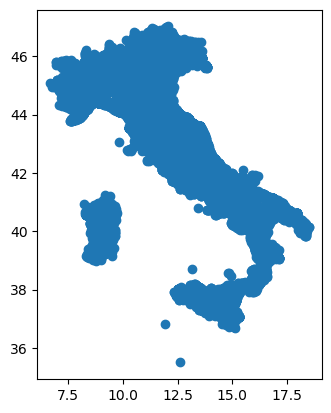

In [24]:
geo_libraries.plot()
plt.show()

## count the total of the libraries for each muncipality of Lombardia

we need the data of the municipalities of Lombardia

here is provided as parquet format 

https://github.com/napo/geospatial_datascience_unitn_2023/raw/main/data/istat/municipalities_lombardia_2022.parquet

### load the data

In [25]:
url2023 = 'https://github.com/napo/geospatial_datascience_unitn_2023/raw/main/data/istat/municipalities_lombardia_2023.parquet'
municipalities2023 = pd.read_parquet(url2023)

In [26]:
municipalities2023.head(3)

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,geometry
0,1,3,19,0,19,19009,019009,Calvatone,None,0,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xea\x00...
1,1,3,19,0,19,19010,019010,Camisano,None,0,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xa5\x00...
2,1,3,19,0,19,19011,019011,Campagnola Cremasca,None,0,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00u\x00\x0...


In [27]:
municipalities2023.geometry[0]

b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xea\x00\x00\x00h"l\xf8\xcb\xc5"A\x18\x04V\xf6\xe9\x12SA`\x10X\xf9\xdd\xc4"A\xaa`T6\xf6\x12SA(\x87\x16\xf9!\xc4"A\xc8):v\x08\x13SA\xf8\x06_\x98\xc8\xc3"A8\xd6\xc5I\x11\x13SA\x08\xb5\xa6\xf9Y\xc3"AV\x0e-6\x1c\x13SA\xe8\xd9\xac\xfa\xb1\xc2"A\xc4\xb1.\xf6+\x13SA\xb0Pk\xfa\xd9\xc1"A\xeeZB6-\x13SA\xc8\xfe\xb2\xfb\x13\xc1"A\xc8):6 \x13SA Zd;\x07\xc1"A\xeeZB6\x1f\x13SA\xe8\xd0"\xfb\x9f\xc0"A\x84/L\xf6\x16\x13SA\xe0\xc7\x98\xfb]\xc0"A8EG\xf6\t\x13SA\xe8\xd0"\xfb=\xc0"A@5^\xf6\xf6\x12SAp\xa3\x01\xfc)\xc0"A\xb0Pk6\xdd\x12SAP\xe3\xa5\xfb\x1d\xc0"A \xf4l\xf6\xc8\x12SA\x90uq\xfb\x17\xc0"A\xd8\x81s\xb6\xba\x12SAp\xac\x8b\xfb\xf3\xbf"AJ\x9d\x80\xb6\xb0\x12SA\x08\x93\xa9\x02\xb0\xbf"A*\xcb\x10W\xaa\x12SA8\x116\xfc\x9b\xbf"A\x8e\x97nv\xa8\x12SAh\x9aw\xfc)\xbf"A"lx\xf6\xa2\x12SA8\x116\xfc\xcf\xbe"A"lx\xf6\xa2\x12SAP\xda\x1b\xfc\x91\xbe"A\xd4\th\xb6\xa7\x12SA8\x116\xfc_\xbe"A&\xe4\x836\xad\x12SA\xe0\xbe\x0e\xdc\x16\xbe"Aj\xdeq\xd6\xb3\x12SA\xa0\x1a/\xfd\x8d\xbd"A\xae

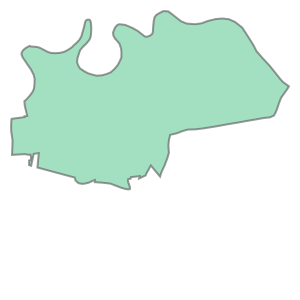

In [28]:
from shapely import from_wkb
from_wkb(municipalities2023.geometry[0])

In [29]:
from_wkb(municipalities2023.geometry[0]).wkt

'POLYGON ((615141.9852 5000103.848999999, 615022.9869999997 5000152.8489, 614928.9864999996 5000225.8473000005, 614884.2976000002 5000261.1526999995, 614828.9875999996 5000304.8465, 614744.9896 5000367.8466, 614636.9890999999 5000372.8478, 614537.9916000003 5000320.8473000005, 614531.6160000004 5000316.8478, 614479.9905000003 5000283.8484000005, 614446.9913999997 5000231.848099999, 614430.9905000003 5000155.8495000005, 614420.9922000002 5000052.850299999, 614414.9914999995 4999971.850400001, 614411.9911000002 4999914.8508, 614393.9912999999 4999874.851600001, 614360.0051999995 4999849.360400001, 614349.9926000005 4999841.850500001, 614292.9930999996 4999819.8511, 614247.9926000005 4999819.8511, 614216.9923999999 4999838.850099999, 614191.9926000005 4999860.8518, 614155.4298 4999887.3507, 614086.9945 4999941.8496, 613973.9948000005 5000005.849199999, 613893.9944000002 5000040.849099999, 613813.9961999999 5000073.8484000005, 613732.9962999998 5000083.8486, 613683.9961000001 5000088.8498,

In [30]:
geo_municipalities2023 = gpd.GeoDataFrame(
    municipalities2023,
    crs="epsg:32632",
    geometry=municipalities2023['geometry'].apply(lambda x:from_wkb(x))
)

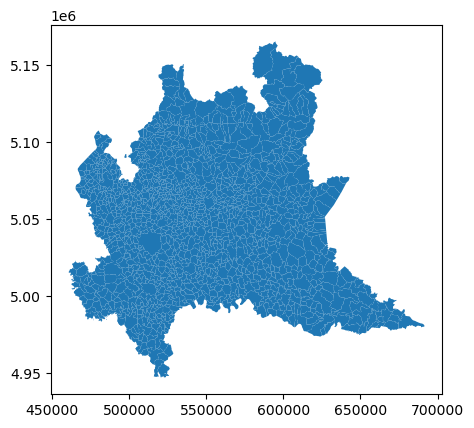

In [31]:
geo_municipalities2023.plot()
plt.show()

### count the points

In [32]:
libraries_municipalities_lombardia = geo_libraries.sjoin(geo_municipalities2023.to_crs(epsg=4326),predicate="within")

[]

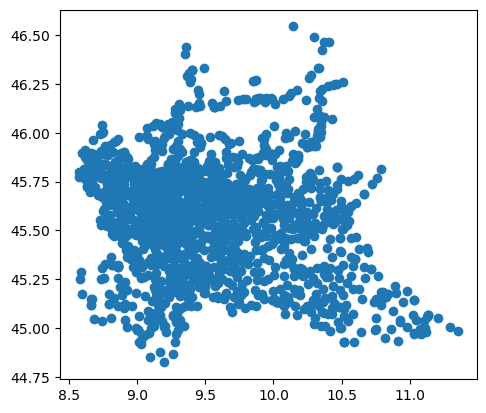

In [33]:
libraries_municipalities_lombardia.plot()
plt.plot()

In [34]:

libraries_municipalities_lombardia.region.unique()

array(['LOMBARDIA'], dtype=object)

In [35]:
libraries_municipalities_lombardia.province.unique()

array(['Bergamo', 'Brescia', 'Como', 'Cremona', 'Lecco', 'Lodi',
       'Monza e della Brianza', 'Milano', 'Pavia', 'Mantova', 'Sondrio',
       'Varese'], dtype=object)

In [36]:
libraries_municipalities_lombardia.COMUNE.value_counts()

Milano                306
Pavia                  96
Brescia                60
Bergamo                44
Mantova                24
                     ... 
Longone al Segrino      1
Lurago d'Erba           1
Lurago Marinone         1
Lurate Caccivio         1
Comabbio                1
Name: COMUNE, Length: 1199, dtype: int64

# 2 - identify the difference of municipalities in Lombardia in the year [2022](https://github.com/napo/geospatial_datascience_unitn_2023/raw/main/data/istat/municipalities_lombardia_2022.parquet) with the year [2023](https://github.com/napo/geospatial_datascience_unitn_2023/raw/main/data/istat/municipalities_lombardia_2023.parquet)


there is the way of geopandas for the geoparquet format

In [37]:
url2022 = 'https://github.com/napo/geospatial_datascience_unitn_2023/raw/main/data/istat/municipalities_lombardia_2022.parquet'
municipalities2022 = pd.read_parquet(url2022)

... or ... you can simple download the file and open it with the methodo .read_parquet() for the GeoDataFrame

In [38]:
# download the file
geo_municipalities2022_file = "municipalities_lombardia_2022.parquet"
r = requests.get(url2022, allow_redirects=True)
open(geo_municipalities2022_file, 'wb').write(r.content)

7047764

In [39]:
geo_municipalities2022 = gpd.read_parquet(geo_municipalities2022_file)

In [40]:
geo_municipalities2022.head(3)

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,geometry
0,1,3,19,0,19,19009,019009,Calvatone,None,0,"POLYGON ((615141.985 5000103.849, 615022.987 5..."
1,1,3,19,0,19,19010,019010,Camisano,None,0,"POLYGON ((557648.422 5035490.598, 557610.424 5..."
2,1,3,19,0,19,19011,019011,Campagnola Cremasca,None,0,"POLYGON ((552290.711 5029539.642, 552320.462 5..."


In [41]:
geo_municipalities2022.crs

<Derived Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

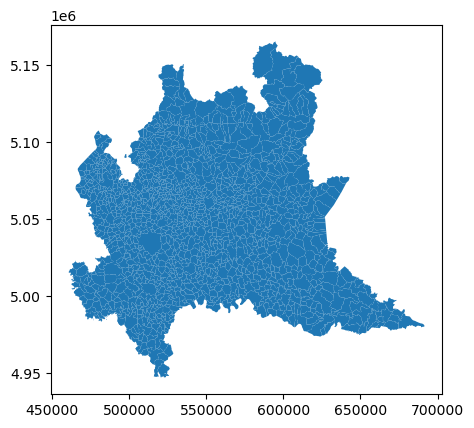

In [42]:
geo_municipalities2022.plot()
plt.show()

and now we are ready to solve the issue

In [43]:
geo_municipalities2022.shape[0]-geo_municipalities2023.shape[0]

2

In [44]:
ids_municipalities2022 = set(list(geo_municipalities2022.PRO_COM_T.unique()))-set(list(geo_municipalities2023.PRO_COM_T.unique()))

In [45]:
ids_municipalities2022

{'012009', '012018', '012095'}

In [46]:
old_municipalities_2022 = geo_municipalities2022[geo_municipalities2022.PRO_COM_T.isin(ids_municipalities2022)]

In [47]:
old_municipalities_2022

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,geometry
29,1,3,12,0,12,12095,012095,Malgesso,None,0,"POLYGON ((475229.531 5075781.302, 475164.531 5..."
115,1,3,12,0,12,12018,012018,Bregano,None,0,"POLYGON ((475548.436 5075395.306, 475487.498 5..."
723,1,3,12,0,12,12009,012009,Bardello,None,0,"POLYGON ((476561.209 5076681.295, 476545.208 5..."


[]

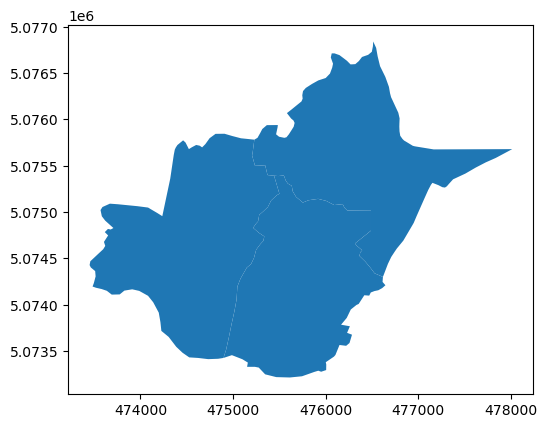

In [48]:
old_municipalities_2022.plot()
plt.plot()

In [49]:
ids_municipalities2023 = set(list(geo_municipalities2023.PRO_COM_T.unique()))-set(list(geo_municipalities2022.PRO_COM_T.unique()))

In [50]:
ids_municipalities2023

{'012144'}

In [51]:
new_municipalities2023 = geo_municipalities2023[geo_municipalities2023.PRO_COM_T.isin(ids_municipalities2023)]

In [52]:
new_municipalities2023

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,geometry
29,1,3,12,0,12,12144,012144,Bardello con Malgesso e Bregano,None,0,"POLYGON ((476561.209 5076681.295, 476545.208 5..."


[]

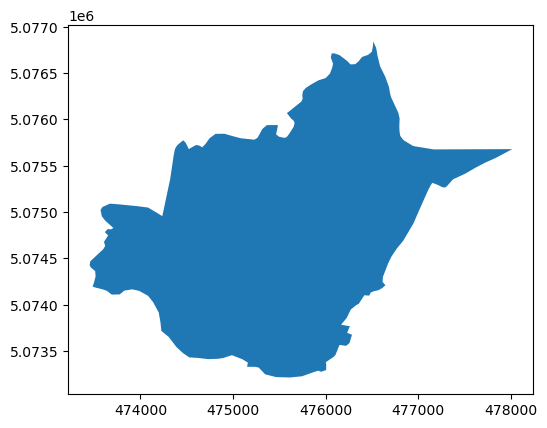

In [53]:
new_municipalities2023.plot()
plt.plot()

the spatial relationship way

In [54]:
def whereincluded(geometry, geometries_gdf):
    name = "not included"
    found = geometries_gdf[geometries_gdf.geometry.contains(geometry)]
    if len(found) > 0:
        name = found.COMUNE.values[0]
    return(name)

In [55]:
old_municipalities_2022['included_in'] = old_municipalities_2022.geometry.apply(lambda g: whereincluded(g,new_municipalities2023))

In [56]:
old_municipalities_2022[['COMUNE','included_in']]

,COMUNE,included_in
29,Malgesso,Bardello con Malgesso e Bregano
115,Bregano,Bardello con Malgesso e Bregano
723,Bardello,Bardello con Malgesso e Bregano


### find the biggest new municipality of Lombardia and show all the italian municipalities with bordering it

In [57]:
biggest_municipality = new_municipalities2023[new_municipalities2023.geometry.area == new_municipalities2023.geometry.area.max()]

In [58]:
boundary = biggest_municipality.geometry.values[0]

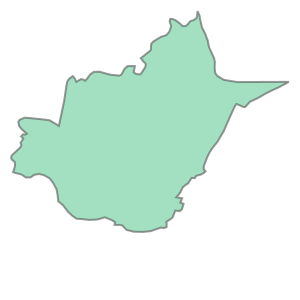

In [59]:
boundary

In [60]:
around = geo_municipalities2023[geo_municipalities2023.touches(boundary)]

In [61]:
around

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,geometry
319,1,3,12,0,12,12128,012128,Travedona-Monate,None,0,"POLYGON ((473636.638 5074149.314, 473580.638 5..."
535,1,3,12,0,12,12072,012072,Gavirate,None,0,"POLYGON ((479663.998 5079326.276, 479703.998 5..."
638,1,3,12,0,12,12014,012014,Biandronno,None,0,"POLYGON ((478096.729 5075580.805, 478081.072 5..."
645,1,3,12,0,12,12017,012017,Brebbia,None,0,"POLYGON ((471908.900 5076370.298, 471884.900 5..."
727,1,3,12,0,12,12013,012013,Besozzo,None,0,"POLYGON ((474104.227 5079428.276, 473999.227 5..."


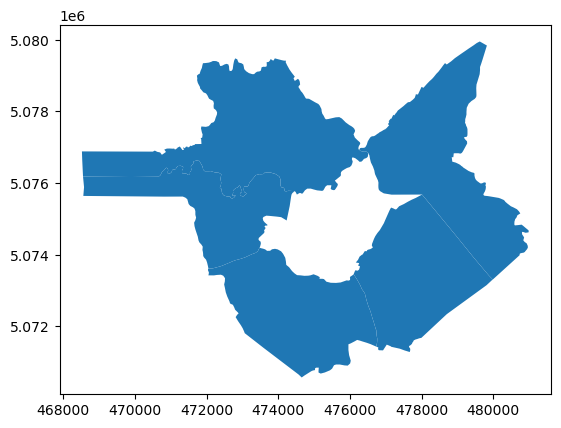

In [62]:
around.plot()
plt.show()

### create the macroarea of all the municipalities bordering with it

In [63]:
new_area = around.append(biggest_municipality).dissolve()

In [64]:
new_area

,geometry,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS
0,"POLYGON ((476573.958 5071506.334, 476468.960 5...",1,3,12,0,12,12128,012128,Travedona-Monate,None,0


In [65]:
new_area['name'] = "macroarea"

<AxesSubplot:>

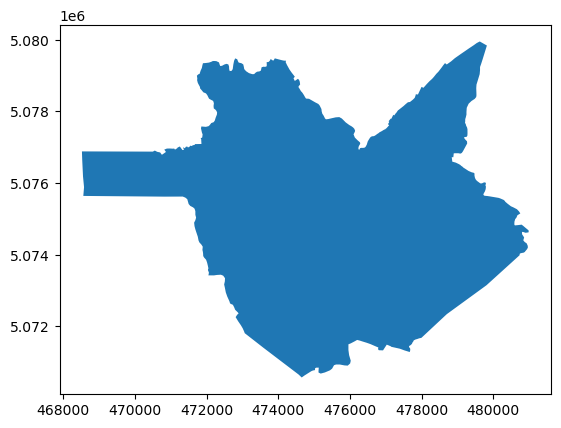

In [66]:
new_area.plot()

### for each library in the macro-area, calculate how many monumental trees have been within a 500m radius

the dataset in GeoJSON of the italian monumental trees is created with the [code of the lesson 02](geospatial_datascience_unitn_2023/code/lectures2_spatial_relationships_and_operations.ipynb)<br/>
You can find the dataset [here](https://raw.githubusercontent.com/napo/geospatial_datascience_unitn_2023/main/data/geo_monumental_trees.geojson)




In [67]:
monumental_trees = gpd.read_file("https://raw.githubusercontent.com/napo/geospatial_datascience_unitn_2023/main/data/geo_monumental_trees.geojson")

In [68]:
cod_prov = new_area.COD_PROV.unique()[0]

In [69]:
area_province_milano = geo_municipalities2023[geo_municipalities2023.COD_PROV == cod_prov].dissolve().to_crs(4326).geometry[0]

In [70]:
trees_in_area = monumental_trees[monumental_trees.geometry.within(area_province_milano)]

In [71]:
trees_in_area.province.unique()

array(['Varese'], dtype=object)

In [72]:
trees500m = trees_in_area.to_crs(epsg=32632).buffer(500).to_crs(epsg=4326)

In [73]:
libraries_500m_from_trees = geo_libraries[geo_libraries.within(trees500m)].shape[0]

In [74]:
print("There are %s monumentals trees 500m from the libraries " % libraries_500m_from_trees)

There are 0 monumentals trees 500m from the libraries 


## 3 - create a polygon that contains all the monumental trees inside the province of the selected area


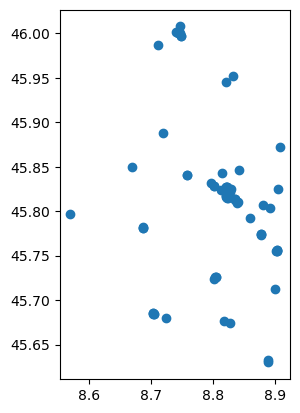

In [75]:
trees_in_area.plot()
plt.show()

In [76]:
trees_in_area.shape[0]

76

In [77]:
trees_in_area_nospatialrel = monumental_trees[monumental_trees.province == "Varese"]

In [78]:
trees_in_area_nospatialrel.shape[0]

76

the total is right ;)

### identify all the libraries in this area which are within 2km of each other

# 3 - creates a polygon that contains all the monumental trees inside the area

## convex hull
solution: create a convex hull<br/>
*In geometry, the convex hull or convex envelope or convex closure of a shape is the smallest convex set that contains it. The convex hull may be defined either as the intersection of all convex sets containing a given subset of a Euclidean space, or equivalently as the set of all convex combinations of points in the subset. For a bounded subset of the plane, the convex hull may be visualized as the shape enclosed by a rubber band stretched around the subset.* (source: [wikipedia](https://en.wikipedia.org/wiki/Convex_hull))

![](https://upload.wikimedia.org/wikipedia/commons/thumb/d/de/ConvexHull.svg/301px-ConvexHull.svg.png)

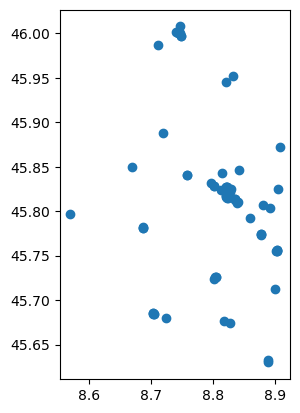

In [79]:
trees_in_area.plot()
plt.show()

In [80]:
trees_in_area_polygon = trees_in_area.unary_union.convex_hull

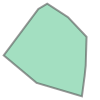

In [81]:
trees_in_area_polygon

## Concave Hull

Contrary to a convex hull, a concave hull can describe the shape of a point cloud. 

Convex hull<br/>
![](https://grass.osgeo.org/grass78/manuals/addons/v_concave_convex.png)
<br/><br/>
Concave hull<br/> 
![](https://grass.osgeo.org/grass78/manuals/addons/v_concave_concave.png)


### Alpha shapes

Alpha shapes are often used to generalize bounding polygons containing sets of points. The alpha parameter is defined as the value a, such that an edge of a disk of radius 1/a can be drawn between any two edge members of a set of points and still contain all the points. The convex hull, a shape resembling what you would see if you wrapped a rubber band around pegs at all the data points, is an alpha shape where the alpha parameter is equal to zero

[https://alphashape.readthedocs.io/](https://alphashape.readthedocs.io/)

In [82]:
try:
  import alphashape
except ModuleNotFoundError as e:
  !pip install alphashape==1.3.1 --break-system-packages
  import alphashape
if alphashape.__version__ != "1.3.1":
  !pip install -U alphashape==1.3.1 --break-system-packages
  import alphashape

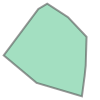

In [83]:
trees_in_area_polygon

In [84]:
alpha_shape = alphashape.alphashape(trees_in_area, 10)


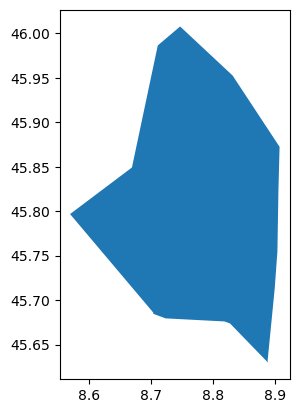

In [85]:
alpha_shape.plot()
plt.show()

... we have only three points ... but if you want try with more ... 

In [86]:
convex_hull = gpd.GeoDataFrame(
    geometry=[trees_in_area_polygon], 
    columns=['geometry'],
    crs=trees_in_area.crs)

convex_hull.explore()

In [87]:
trees_in_area.explore()

In [88]:
alpha_paramenter = 10
alphashape.alphashape(trees_in_area, alpha_paramenter).explore()

Creating alpha shapes around sets of points usually requires a visually interactive step where the alpha parameter for a concave hull is determined by iterating over or bisecting values to approach a best fit. 

More informations: [https://alphashape.readthedocs.io/en/latest/readme.html#using-a-varying-alpha-parameter](https://alphashape.readthedocs.io/en/latest/readme.html#using-a-varying-alpha-parameter)

## identify all the libraries in Lombardia which are within 2km of each other

In [89]:
libraries_municipalities_lombardia.shape[0]

2063

## nearest points

In [90]:
from shapely.ops import nearest_points

shapely offers a method to identify the nearest points between two geometries<br/>
Documentation [here](https://shapely.readthedocs.io/en/stable/manual.html#shapely.ops.nearest_points)


In [91]:
libraries_municipalities_lombardia['nearest_id'] = ""
libraries_municipalities_lombardia['distance'] = -1
for idx, row in libraries_municipalities_lombardia.to_crs(epsg=32632).iterrows():
    isil = row['isil']
    point = row['geometry']
    multipoints = libraries_municipalities_lombardia[libraries_municipalities_lombardia.isil != isil]["geometry"].to_crs(epsg=32632).unary_union
    nearest_geoms = nearest_points(point, multipoints)
    maxdistance = 0
    nearest_id = ""
    for pn in nearest_geoms:
        dist = point.distance(pn)
        if (dist > maxdistance and dist <= 2000):
            nearest_id = libraries_municipalities_lombardia[libraries_municipalities_lombardia.to_crs(epsg=32632).geometry == pn]['isil'].values[0]
            maxdistance = dist
    libraries_municipalities_lombardia.loc[idx,"distance"] = maxdistance
    libraries_municipalities_lombardia.loc[idx,"nearest_id"] = nearest_id
%time

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10.3 µs


In [92]:
libraries_municipalities_lombardia

,isil,sbn,name,address,village,zipcode,city,istat_city,province,region,...,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,nearest_id,distance
1055,IT-BG0001,NaN,Biblioteca comunale,Piazza Umberto I 24,NaN,24060,Adrara San Martino,16001,Bergamo,LOMBARDIA,...,16,0,16,16001,016001,Adrara San Martino,None,0,IT-BG0002,1829.130308
1056,IT-BG0002,NaN,Biblioteca comunale Eugenio Donadoni,Via Mafessini 2,NaN,24060,Adrara San Rocco,16002,Bergamo,LOMBARDIA,...,16,0,16,16002,016002,Adrara San Rocco,None,0,IT-BG0001,1829.130308
1057,IT-BG0003,NaN,Biblioteca comunale Carlo Cattaneo,Piazza Caduti per La Patria 4,NaN,24061,Albano Sant'Alessandro,16003,Bergamo,LOMBARDIA,...,16,0,16,16003,016003,Albano Sant'Alessandro,None,0,IT-BG0233,1569.878058
1058,IT-BG0005,NaN,Biblioteca comunale,Via G. Mazzini 68,NaN,24021,Albino,16004,Bergamo,LOMBARDIA,...,16,0,16,16004,016004,Albino,None,0,IT-BG0391,606.819250
1318,IT-BG0391,NaN,Biblioteca Leone Dehon,"Via Padre Leone Dehon, 1",NaN,24021,Albino,16004,Bergamo,LOMBARDIA,...,16,0,16,16004,016004,Albino,None,0,IT-BG0005,606.819250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12350,IT-VA0293,NaN,Biblioteca comunale L. Stadera,Piazza Libertà 1,NaN,21020,Cazzago Brabbia,12049,Varese,LOMBARDIA,...,12,0,12,12049,012049,Cazzago Brabbia,None,0,IT-VA0175,1224.260924
12352,IT-VA0295,NaN,Biblioteca Comunale,Vicolo del Torchio 2,NaN,21010,Germignaga,12076,Varese,LOMBARDIA,...,12,0,12,12076,012076,Germignaga,None,0,IT-VA0084,1540.231970
12353,IT-VA0296,NaN,Biblioteca comunale di Valganna,Via Tabacchi 7,Ganna,21039,Valganna,12131,Varese,LOMBARDIA,...,12,0,12,12131,012131,Valganna,None,0,,0.000000
12354,IT-VA0297,NaN,Biblioteca comunale,Via Gianoli snc,NaN,21030,Masciago Primo,12100,Varese,LOMBARDIA,...,12,0,12,12100,012100,Masciago Primo,None,0,IT-VA0289,776.913794


In [93]:
libraries_municipalities_lombardia[['isil','name','city','nearest_id','distance']]

,isil,name,city,nearest_id,distance
1055,IT-BG0001,Biblioteca comunale,Adrara San Martino,IT-BG0002,1829.130308
1056,IT-BG0002,Biblioteca comunale Eugenio Donadoni,Adrara San Rocco,IT-BG0001,1829.130308
1057,IT-BG0003,Biblioteca comunale Carlo Cattaneo,Albano Sant'Alessandro,IT-BG0233,1569.878058
1058,IT-BG0005,Biblioteca comunale,Albino,IT-BG0391,606.819250
1318,IT-BG0391,Biblioteca Leone Dehon,Albino,IT-BG0005,606.819250
...,...,...,...,...,...
12350,IT-VA0293,Biblioteca comunale L. Stadera,Cazzago Brabbia,IT-VA0175,1224.260924
12352,IT-VA0295,Biblioteca Comunale,Germignaga,IT-VA0084,1540.231970
12353,IT-VA0296,Biblioteca comunale di Valganna,Valganna,,0.000000
12354,IT-VA0297,Biblioteca comunale,Masciago Primo,IT-VA0289,776.913794


In [94]:
libraries_municipalities_lombardia[libraries_municipalities_lombardia.distance > 0]

TypeError: '>' not supported between instances of 'method' and 'int'

## 4 - create the polygon of the Island of Elba from the layer of municipalities with functions of overlay

- identify Elba Island
- generate an area around the island
- clip the geometry


open [umap](https://umap.openstreetmap.eu) and draw an area around [Elba](https://en.wikipedia.org/wiki/Elba) Island and download it in geojson format 

![](https://raw.githubusercontent.com/napo/geospatial_datascience_unitn_2023/main/images/isola_elba.gif)

the geojson file is available also here [https://raw.githubusercontent.com/napo/geospatial_datascience_unitn_2023/main/data/elbaisland.geojson](https://raw.githubusercontent.com/napo/geospatial_datascience_unitn_2023/main/data/elbaisland.geojson)

In [ ]:
url_area = "https://raw.githubusercontent.com/napo/geospatial_datascience_unitn_2023/main/data/elbaisland.geojson"
area_around_elba = gpd.read_file(url_area)

In [ ]:
macroregions23 = gpd.read_file("https://media.githubusercontent.com/media/napo/geospatial_datascience_unitn_2023/main/data/istat/istat_administrative_units_2023.gpkg",layer="macroregions")
municipalities23 = gpd.read_file("https://media.githubusercontent.com/media/napo/geospatial_datascience_unitn_2023/main/data/istat/istat_administrative_units_2023.gpkg",layer="municipalities")

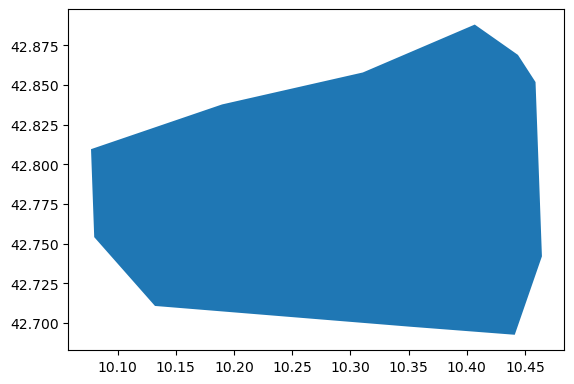

In [ ]:
area_around_elba.plot()
plt.show()

In [ ]:
gdf_clipped_area = gpd.clip(macroregions23.to_crs(epsg=4326), area_around_elba, keep_geom_type=False)


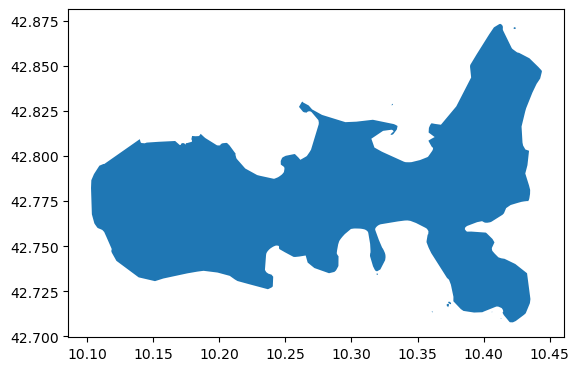

In [ ]:
gdf_clipped_area.plot()
plt.show()

In [ ]:
elba_island = gdf_clipped_area.dissolve()

In [ ]:
elba_island

,geometry,COD_RIP,DEN_RIP
0,"MULTIPOLYGON (((10.36101 42.71325, 10.36105 42...",3,Centro


remove not usefull columns

In [ ]:
del elba_island['COD_RIP']

In [ ]:
del elba_island['DEN_RIP']

In [ ]:
elba_island['name'] = "Elba"

In [ ]:
elba_island

,geometry,name
0,"MULTIPOLYGON (((10.36101 42.71325, 10.36105 42...",Elba


if you want to know the names of the municipalities on the Island of Elba

In [ ]:
municipalities_in_elba = municipalities23[municipalities23.to_crs(epsg=4326).geometry.intersects(elba_island.geometry.values[0]) == True]
%time

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


In [ ]:
municipalities_in_elba

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,geometry
4328,3,9,49,0,49,49003,049003,Campo nell'Elba,NaN,0,"MULTIPOLYGON (((590833.850 4715112.608, 590819..."
4329,3,9,49,0,49,49004,049004,Capoliveri,NaN,0,"MULTIPOLYGON (((615738.398 4729548.981, 615737..."
4335,3,9,49,0,49,49010,049010,Marciana,NaN,0,"MULTIPOLYGON (((593200.087 4740268.899, 593249..."
4336,3,9,49,0,49,49011,049011,Marciana Marina,NaN,0,"MULTIPOLYGON (((596961.056 4740648.895, 597171..."
4338,3,9,49,0,49,49013,049013,Porto Azzurro,NaN,0,"MULTIPOLYGON (((613705.918 4738969.904, 614531..."
4339,3,9,49,0,49,49014,049014,Portoferraio,NaN,0,"MULTIPOLYGON (((609591.668 4686406.686, 608403..."
4344,3,9,49,0,49,49021,049021,Rio,NaN,0,"MULTIPOLYGON (((626486.816 4746023.842, 626396..."


or

In [ ]:
municipalities_in_elba = gpd.clip(municipalities23.to_crs(epsg=4326), area_around_elba, keep_geom_type=False)
%time

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


In [ ]:
municipalities_in_elba

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,geometry
4339,3,9,49,0,49,49014,049014,Portoferraio,NaN,0,"MULTIPOLYGON (((10.33035 42.82805, 10.33052 42..."
4328,3,9,49,0,49,49003,049003,Campo nell'Elba,NaN,0,"POLYGON ((10.23976 42.77261, 10.24110 42.77261..."
4335,3,9,49,0,49,49010,049010,Marciana,NaN,0,"POLYGON ((10.14049 42.80775, 10.14061 42.80756..."
4336,3,9,49,0,49,49011,049011,Marciana Marina,NaN,0,"POLYGON ((10.18851 42.81053, 10.18944 42.80994..."
4329,3,9,49,0,49,49004,049004,Capoliveri,NaN,0,"MULTIPOLYGON (((10.41330 42.70967, 10.41278 42..."
4338,3,9,49,0,49,49013,049013,Porto Azzurro,NaN,0,"POLYGON ((10.40043 42.79194, 10.40113 42.79210..."
4344,3,9,49,0,49,49021,049021,Rio,NaN,0,"MULTIPOLYGON (((10.42397 42.87046, 10.42292 42..."


PS: 

If someone tells you that there are 7 municipalities in Elba, tell them they are wrong:
The Municipality of Rio was established in *2018* following the merger of the municipalities of Rio d'Elba, Rio Marina and others.

[https://en.wikipedia.org/wiki/Rio,_Italy](https://en.wikipedia.org/wiki/Rio,_Italy)

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/rio_wikipedia.png)

# The use of the Spatial SQL

![](https://raw.githubusercontent.com/napo/geospatial_datascience_unitn_2023/main/images/introduckdb.png)<br/>
![](https://raw.githubusercontent.com/napo/geospatial_datascience_unitn_2023/main/images/whyduckdb.png)

load dataset from http<br/>
[https://duckdb.org/docs/archive/0.9.0/guides/import/http_import](https://duckdb.org/docs/archive/0.9.0/guides/import/http_import)

```sql
napo@datascience:~$ duckdb 
v0.9.0 0d84ccf478
Enter ".help" for usage hints.
Connected to a transient in-memory database.
Use ".open FILENAME" to reopen on a persistent database.
D install httpfs;
D load https;
D 
```

we have the (geo)parquet file here - https://github.com/napo/geospatial_datascience_unitn_2023/raw/main/data/istat/municipalities_lombardia_2023.parquet

We can reach with this syntax
```sql
SELECT * FROM read_parquet('https://github.com/napo/geospatial_datascience_unitn_2023/raw/main/data/istat/municipalities_lombardia_2023.parquet') limit 3
```

but before we have to install httpfs module and load it

```sql
D INSTALL httpfs;
D LOAD httpfs;
```

```sql
D SELECT * FROM read_parquet('https://github.com/napo/geospatial_datascience_uni
┌─────────┬─────────┬──────────┬───┬──────────┬────────┬──────────────────────┐
│ COD_RIP │ COD_REG │ COD_PROV │ … │ COMUNE_A │ CC_UTS │       geometry       │
│  int64  │  int64  │  int64   │   │ varchar  │ int64  │         blob         │
├─────────┼─────────┼──────────┼───┼──────────┼────────┼──────────────────────┤
│       1 │       3 │       19 │ … │          │      0 │ \x01\x03\x00\x00\x…  │
│       1 │       3 │       19 │ … │          │      0 │ \x01\x03\x00\x00\x…  │
│       1 │       3 │       19 │ … │          │      0 │ \x01\x03\x00\x00\x…  │
├─────────┴─────────┴──────────┴───┴──────────┴────────┴──────────────────────┤
│ 3 rows                                                 11 columns (6 shown) │
└─────────────────────────────────────────────────────────────────────────────┘
D 

```

```sql
D DESCRIBE (select * FROM read_parquet('https://github.com/napo/geospatial_datascience_unitn_2023/raw/main/data/istat/municipalities_lombardia_2023.parquet'));
┌─────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│ column_name │ column_type │  null   │   key   │ default │  extra  │
│   varchar   │   varchar   │ varchar │ varchar │ varchar │ varchar │
├─────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ COD_RIP     │ BIGINT      │ YES     │         │         │         │
│ COD_REG     │ BIGINT      │ YES     │         │         │         │
│ COD_PROV    │ BIGINT      │ YES     │         │         │         │
│ COD_CM      │ BIGINT      │ YES     │         │         │         │
│ COD_UTS     │ BIGINT      │ YES     │         │         │         │
│ PRO_COM     │ BIGINT      │ YES     │         │         │         │
│ PRO_COM_T   │ VARCHAR     │ YES     │         │         │         │
│ COMUNE      │ VARCHAR     │ YES     │         │         │         │
│ COMUNE_A    │ VARCHAR     │ YES     │         │         │         │
│ CC_UTS      │ BIGINT      │ YES     │         │         │         │
│ geometry    │ BLOB        │ YES     │         │         │         │
├─────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┤
│ 11 rows                                                 6 columns │
└───────────────────────────────────────────────────────────────────┘

```

and now we can extend to the use of the spatial sql



# The use of the Spatial SQL

![](https://raw.githubusercontent.com/napo/geospatial_datascience_unitn_2023/main/images/duckdbspatial.png)

more info [https://duckdb.org/docs/extensions/spatial](https://duckdb.org/docs/extensions/spatial)

```sql
D INSTALL spatial;
D LOAD spatial;
```

Special thanks to [aborruso](https://github.com/aborruso)


![](https://raw.githubusercontent.com/napo/geospatial_datascience_unitn_2023/main/images/aborruso.png)

 ```sql
 select ST_GeomFromWKB(geometry) FROM read_parquet('https://github.com/napo/geospatial_datascience_unitn_2023/raw/main/data/istat/municipalities_lombardia_2023.parquet') limit 3;
┌──────────────────────────────────────────────────────────────────────────────┐
│                           st_geomfromwkb(geometry)                           │
│                                   geometry                                   │
├──────────────────────────────────────────────────────────────────────────────┤
│ POLYGON ((615141.9852 5000103.848999999, 615022.9869999997 5000152.8489, 6…  │
│ POLYGON ((557648.4221000001 5035490.5978, 557610.4238 5035558.597100001, 5…  │
│ POLYGON ((552290.7105999999 5029539.642200001, 552320.4617999997 5029257.6…  │
└──────────────────────────────────────────────────────────────────────────────┘
D 
``````

```sql
select COMUNE, ST_GeomFromWKB(geometry) FROM read_parquet('https://github.com/napo/geospatial_datascience_unitn_2023/raw/main/data/istat/municipalities_lombardia_2023.parquet') where COMUNE='Milano';
```

```sql
┌─────────┬───────────────────────────────────────────────────────────────────────────────────┐
│ COMUNE  │                             st_geomfromwkb(geometry)                              │
│ varchar │                                     geometry                                      │
├─────────┼───────────────────────────────────────────────────────────────────────────────────┤
│ Milano  │ POLYGON ((513714.53839999996 5042508.055600001, 513590.0706000002 5042502.05980…  │
└─────────┴───────────────────────────────────────────────────────────────────────────────────┘
```

```sql
select COMUNE as city, ST_Area(ST_GeomFromWKB(geometry)) as area FROM read_parquet('https://github.com/napo/geospatial_datascience_unitn_2023/raw/main/data/istat/municipalities_lombardia_2023.parquet') where COMUNE='Milano';
```

```sql
┌─────────┬────────────────────┐
│  city   │        area        │
│ varchar │       double       │
├─────────┼────────────────────┤
│ Milano  │ 181678305.81998348 │
└─────────┴────────────────────┘
```

```sql
select COMUNE as city, ST_TRANSFORM(ST_GeomFromWKB(geometry),'EPSG:32632','EPSG:4326') as geometry FROM read_parquet('https://github.com/napo/geospatial_datascience_unitn_2023/raw/main/data/istat/municipalities_lombardia_2023.parquet') where COMUNE='Milano';
```

```sql
┌─────────┬────────────────────────────────────────────────────────────────────┐
│  city   │                                area                                │
│ varchar │                              geometry                              │
├─────────┼────────────────────────────────────────────────────────────────────┤
│ Milano  │ POLYGON ((45.53597335267478 9.17565394192136, 45.53592182443006 …  │
└─────────┴────────────────────────────────────────────────────────────────────┘
```

## Play with different sources


In [95]:
geo_libraries.to_file("italian_libraries.geojson")

note: run duckdb from the same directory where you stored the file italian_libraries.geojson 

```sql
D DESCRIBE (SELECT * FROM ST_Read('italian_libraries.geojson'));
┌────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│  column_name   │ column_type │  null   │   key   │ default │  extra  │
│    varchar     │   varchar   │ varchar │ varchar │ varchar │ varchar │
├────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ isil           │ VARCHAR     │ YES     │         │         │         │
│ sbn            │ VARCHAR     │ YES     │         │         │         │
│ name           │ VARCHAR     │ YES     │         │         │         │
│ address        │ VARCHAR     │ YES     │         │         │         │
│ village        │ VARCHAR     │ YES     │         │         │         │
│ zipcode        │ INTEGER     │ YES     │         │         │         │
│ city           │ VARCHAR     │ YES     │         │         │         │
│ istat_city     │ INTEGER     │ YES     │         │         │         │
│ province       │ VARCHAR     │ YES     │         │         │         │
│ region         │ VARCHAR     │ YES     │         │         │         │
│ istat_province │ INTEGER     │ YES     │         │         │         │
│ latitude       │ DOUBLE      │ YES     │         │         │         │
│ longitude      │ DOUBLE      │ YES     │         │         │         │
│ phone          │ VARCHAR     │ YES     │         │         │         │
│ fax            │ VARCHAR     │ YES     │         │         │         │
│ email          │ VARCHAR     │ YES     │         │         │         │
│ url            │ VARCHAR     │ YES     │         │         │         │
│ geom           │ GEOMETRY    │ YES     │         │         │         │
├────────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┤
│ 18 rows                                                    6 columns │
└──────────────────────────────────────────────────────────────────────┘
```

```sql
CREATE TABLE municipalities AS 
    SELECT COMUNE AS city, ST_Transform(ST_GeomFromWKB(geometry),'EPSG:32632','EPSG:4326') AS geometry 
    FROM read_parquet('https://github.com/napo/geospatial_datascience_unitn_2023/raw/main/data/istat/municipalities_lombardia_2023.parquet');
````

```sql
CREATE TABLE libraries as
SELECT 
    name, 
    address, 
    city, 
    libraries.geom as geometry,
    FROM ST_Read('italian_libraries.geojson') as libraries;
```


```sql
SELECT libraries.name, libraries.city as city_library,
    municipalities.city as city_municipality
    FROM libraries, municipalities 
    WHERE ST_WITHIN(libraries.geometry, municipalities.geometry);
``````

```sql 
┌─────────┬─────────┬─────────┐
│  name   │ address │  city   │
│ varchar │ varchar │ varchar │
├─────────────────────────────┤
│           0 rows            │
└─────────────────────────────┘
``````

ZERO???

```sql
D SELECT ST_Centroid(geometry) FROM municipalities WHERE city='Milano';
┌────────────────────────────────────────────┐
│           st_centroid(geometry)            │
│                  geometry                  │
├────────────────────────────────────────────┤
│ POINT (45.46844508758169 9.17291989975188) │
└────────────────────────────────────────────┘
D SELECT geometry FROM libraries WHERE city='Milano' LIMIT 1;
┌──────────────────────────────┐
│           geometry           │
│           geometry           │
├──────────────────────────────┤
│ POINT (9.1877061 45.4768732) │
└──────────────────────────────┘
```

GeoJSON store the coordinates in the sequence Y,X<Br/>
Geoparquet store the coordinate in the sequence X,Y

... we need to invert 

The syntax of WKT is X,Y

```sql
SELECT libraries.name, libraries.city as city_library,
    municipalities.city as city_municipality
    FROM libraries, municipalities 
    WHERE ST_WITHIN(ST_FlipCoordinates(libraries.geometry), municipalities.geometry) limit 3;
```

```sql
┌─────────────────────────────────────────────────────────┬────────────────────┬────────────────────┐
│                          name                           │    city_library    │ city_municipality  │
│                         varchar                         │      varchar       │      varchar       │
├─────────────────────────────────────────────────────────┼────────────────────┼────────────────────┤
│ Biblioteca comunale Cesare Zavattini - Sede di Felonica │ Sermide e Felonica │ Sermide e Felonica │
│ Biblioteca comunale                                     │ Sermide e Felonica │ Sermide e Felonica │
│ Biblioteca comunale di Borgocarbonara                   │ Borgocarbonara     │ Borgocarbonara     │
└─────────────────────────────────────────────────────────┴────────────────────┴────────────────────┘
```

```sql
SELECT count(*)
    FROM libraries, municipalities 
    WHERE ST_WITHIN(ST_FlipCoordinates(libraries.geometry), municipalities.geometry);
```

```sql 
┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│         2063 │
└──────────────┘
```

Export in geojson format
```sql 
COPY (
    SELECT libraries.name, libraries.city as city_library,
        municipalities.city as city_municipality, libraries.geometry
        FROM libraries, municipalities 
     WHERE ST_WITHIN(ST_FlipCoordinates(libraries.geometry), municipalities.geometry)
) TO 'libraries_lombardia.geojson'
WITH (FORMAT GDAL, DRIVER 'GeoJSON');
```

In [100]:
gpd.read_file("libraries_lombardia.geojson").explore()